# Домашняя работа №7
1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
2.	И затем обучить Модель на выбор из segmentation_models_pytorch


In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
tqdm.pandas()

learning_rate = 0.0001
epochs = 10

In [2]:
folder = 'set-lipstick-original'

In [3]:
df = pd.read_csv(f"{folder}/list.csv")[['filename', 'mask']]
# Добавим пути
df['filename'] = f"{folder}/720p/" + df['filename'] 
df['mask'] = f"{folder}/mask/" + df['mask'] 
df

,filename,mask
0,set-lipstick-original/720p/image00000001.jpg,set-lipstick-original/mask/mask00000001.png
1,set-lipstick-original/720p/image00000002.jpg,set-lipstick-original/mask/mask00000002.png
2,set-lipstick-original/720p/image00000003.jpg,set-lipstick-original/mask/mask00000003.png
3,set-lipstick-original/720p/image00000004.jpg,set-lipstick-original/mask/mask00000004.png
4,set-lipstick-original/720p/image00000005.jpg,set-lipstick-original/mask/mask00000005.png
...,...,...
28589,set-lipstick-original/720p/image00028590.jpg,set-lipstick-original/mask/mask00028590.png
28590,set-lipstick-original/720p/image00028591.jpg,set-lipstick-original/mask/mask00028591.png
28591,set-lipstick-original/720p/image00028592.jpg,set-lipstick-original/mask/mask00028592.png
28592,set-lipstick-original/720p/image00028593.jpg,set-lipstick-original/mask/mask00028593.png


In [4]:
def opener(row):
    try:
        with open(row, 'rb') as file:
            file.read()
        return True
    except: return False

# Обнаружим файлы которых нет
df['filename_found'] = df['filename'].progress_apply(opener)
df['mask_found'] = df['mask'].progress_apply(opener)

100%|█████████████████████████████████████████████████████████████████████████| 28594/28594 [00:01<00:00, 17413.84it/s]


In [5]:
df['filename_found'].value_counts()

True    28594
Name: filename_found, dtype: int64

In [6]:
df['mask_found'].value_counts()

True     28540
False       54
Name: mask_found, dtype: int64

In [7]:
# Выкинем строки где нет файла
df = df[(df['mask_found'] == True) & (df['filename_found'] == True)]
df

,filename,mask,filename_found,mask_found
0,set-lipstick-original/720p/image00000001.jpg,set-lipstick-original/mask/mask00000001.png,True,True
1,set-lipstick-original/720p/image00000002.jpg,set-lipstick-original/mask/mask00000002.png,True,True
2,set-lipstick-original/720p/image00000003.jpg,set-lipstick-original/mask/mask00000003.png,True,True
3,set-lipstick-original/720p/image00000004.jpg,set-lipstick-original/mask/mask00000004.png,True,True
4,set-lipstick-original/720p/image00000005.jpg,set-lipstick-original/mask/mask00000005.png,True,True
...,...,...,...,...
28589,set-lipstick-original/720p/image00028590.jpg,set-lipstick-original/mask/mask00028590.png,True,True
28590,set-lipstick-original/720p/image00028591.jpg,set-lipstick-original/mask/mask00028591.png,True,True
28591,set-lipstick-original/720p/image00028592.jpg,set-lipstick-original/mask/mask00028592.png,True,True
28592,set-lipstick-original/720p/image00028593.jpg,set-lipstick-original/mask/mask00028593.png,True,True


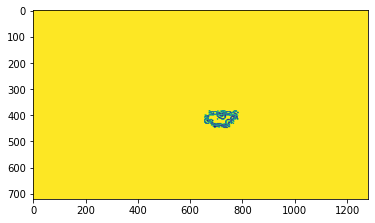

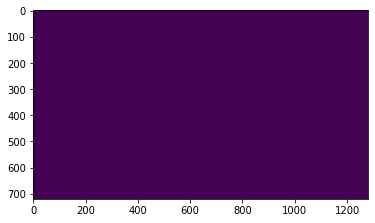

In [8]:
for i in range(2):
    mask = plt.imread('set-lipstick-original/mask/mask00000001.png')
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.imshow(mask)
    plt.show()

## 1-й вариант запуска по образцу с урока

In [10]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        lab = np.asarray(plt.imread(self.label_arr[index])).astype('float')[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [13]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.6867) tensor(0.1983)


In [14]:
data[0].shape, data[1].shape

(torch.Size([1, 1, 3, 256, 256]), torch.Size([1, 1, 1, 256, 256]))

In [15]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [18]:
import segmentation_models_pytorch as smp
device = torch.device('cpu')  # На GPU почему то глючит из-за ошибок

# создание модели
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=learning_rate)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in tqdm(enumerate(train_data_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = dice_loss(outputs, labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


RuntimeError: index 3 is out of bounds for dimension 1 with size 2

#### Возможно что-то не так с размерностью, но я просто взял данный вариант с урока и поменял кол-во классов с 13-и на 2
#### Ошибка возникает в самописной лосс-функции, вынесем код из функции чтоб у нас была возможность дотянуться до переменных, посмотреть размерность

In [19]:
# def dice_loss(output, target, weights=None, ignore_index=None):
#          АРГУМЕНТЫ ФУНКЦИИ
output = outputs
target = labels[0,0,:,:,:]
weights=None
ignore_index=None

eps = 0.0001

output = output.float().exp()
target = target.type(torch.int64)
encoded_target = output.detach() * 0
if ignore_index is not None:
    mask = target == ignore_index
    target = target.clone()
    target[mask] = 0
    encoded_target.scatter_(1, target.unsqueeze(1), 1)
    mask = mask.unsqueeze(1).expand_as(encoded_target)
    encoded_target[mask] = 0
else:
    encoded_target.scatter_(1, target.unsqueeze(1), 1)

if weights is None:
    weights = 1

intersection = output * encoded_target
numerator = 2 * intersection.sum(0).sum(1).sum(1)
denominator = output + encoded_target

if ignore_index is not None:
    denominator[mask] = 0
denominator = denominator.sum(0).sum(1).sum(1) + eps
loss_per_channel = weights * (1 - (numerator / denominator))

loss_per_channel.sum() / output.size(1)

RuntimeError: index 3 is out of bounds for dimension 1 with size 2

#### Ошибка возникает здесь, посмотрим на размерности тензоров

In [20]:
encoded_target.scatter_(1, target.unsqueeze(1), 1)

RuntimeError: index 3 is out of bounds for dimension 1 with size 2

#### Да вроде сходится, не понимаю в чем причина

In [22]:
encoded_target.shape, target.unsqueeze(1).shape

(torch.Size([1, 2, 256, 256]), torch.Size([1, 1, 256, 256]))

#### В любом случае, я обнаружил что Unet из segmentation_models_pytorch учат через smp.utils.train.TrainEpoch и smp.utils.train.ValidEpoch
## Поэтому пробую вариант №2

In [9]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        lab = np.asarray(plt.imread(self.label_arr[index])).astype('float')[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float()[0, ...], lab.float()[0, ...]) # Изменим размерности, а то библиотека ругается 

    def __len__(self):
        return self.data_len

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [12]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.4766) tensor(0.2148)


In [13]:
data[0].shape, data[1].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

#### В каком-то моменте возникнет ошибка, не понимаю что происходит - все изображения должны быть одинаковых размерностей по идее

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Здесь GPU уже без ошибок работает

# создание модели
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=learning_rate)
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
train_epoch = utils.train.TrainEpoch(segmodel,
                                     loss=loss,
                                     metrics=metrics,
                                     optimizer=optimizer,
                                     device=device,
                                     verbose=True)

valid_epoch = utils.train.ValidEpoch(segmodel,
                                     loss=loss,
                                     metrics=metrics,
                                     device=device,
                                     verbose=True)


train_logs_list = []
valid_logs_list = []

for epoch in tqdm(range(1)):  # Только одну эпоху сделаем
    
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


train:   0%|                             | 1/19978 [00:02<14:26:20,  2.60s/it, dice_loss - 0.9177, iou_score - 0.04289]

C:\ProgramData\Anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)



train:  17%|█████                         | 3375/19978 [04:41<22:58, 12.05it/s, dice_loss - 0.917, iou_score - 0.04397]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




train:  25%|███████▎                     | 5055/19978 [07:00<20:22, 12.20it/s, dice_loss - 0.9174, iou_score - 0.04369]

train:  33%|█████████▍                   | 6505/19978 [09:00<18:31, 12.13it/s, dice_loss - 0.9174, iou_score - 0.04367]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train:  49%|██████████████▏              | 9769/19978 [13:30<14:01, 12.13it/s, dice_loss - 0.9172, iou_score - 0.04381]

train:  56%|███████████████▋            | 11219/19978 [15:31<11:56, 12.23it/s, dice_loss - 0.9174, iou_score - 0.04369]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




train:  62%|█████████████████▍          | 12399/19978 [17:09<10:38, 11.86it/s, dice_loss - 0.9176, iou_score - 0.04355]

train:  68%|███████████████████         | 13569/19978 [18:46<08:52, 12.05it/s, dice_loss - 0.9177, iou_score - 0.04352]

  0%|                                                                                            | 0/1 [18:46<?, ?it/s]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed